<a href="https://colab.research.google.com/github/LokeshJatangi/EVA-vision/blob/master/Project6/Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model
from keras.layers.convolutional import Conv2D, MaxPooling2D ,SeparableConv2D
from keras.layers.merge import concatenate
from keras.layers import Activation, Flatten, Input, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

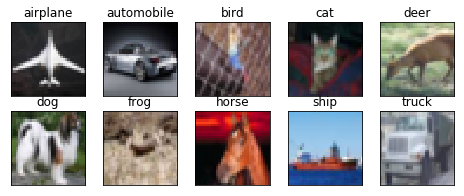

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Functional Api 

In [0]:

# Define the model

inputs = Input(shape=(32,32 , 3), name = 'input_images')

# Normal Convolution
layer_1  = Conv2D(filters=32,kernel_size=(3,3),activation='relu',border_mode='same',name='NormConv_01')(inputs)  #Output = (32x32x32) ,RF= 2x2
layer_1  = BatchNormalization()(layer_1)

# Spatially Separable Convolution
layer_2a  = Conv2D(64, 1, 3,activation='relu',name='Spatial_Sep_1a')(layer_1) #Output = (30x32x64) ,RF= 4x2
layer_2  = Conv2D(64, 3, 1,activation='relu',name='Spatial_Sep_1b')(layer_2a) #Output = (30x30x64) ,RF= 4x4
layer_2  = BatchNormalization()(layer_2)
                  
# Depthwise Separable Convolution
layer_3 = SeparableConv2D(128 , 3, 3, activation='relu',border_mode='same', name = 'DepthSep_01')(layer_2) #Output = (30x30x128) ,RF= 6x6
layer_3  = BatchNormalization()(layer_3)
    
# Max pooling                  
pooling_layer_1 = MaxPooling2D(pool_size=(2,2))(layer_3) #Output = (15x15x128) ,RF= 12x12                  
          
# Transition layer
layer_4  = Conv2D(32, 1, 1,activation='relu',name='TransLayer')(pooling_layer_1) #Output = (15x15x32) ,RF= 12x12
layer_4 = BatchNormalization()(layer_4)

                  
# Grouped Convolution
GP_layer_1a = Conv2D(64,3,3,activation='relu',border_mode='same',name='GroupConv_1a')(layer_4)#Output = (15x15x64) ,RF= 14x14
GP_layer_1b = Conv2D(64,5,5,activation='relu',border_mode='same',name='GroupConv_1b')(layer_4)#Output = (15x15x64) ,RF= 16x16
 
   ## Merging Group Convolution of (3x3 and 5x5)
layer_5 = concatenate([GP_layer_1a,GP_layer_1b],axis=-1)#Output = (15x15x128) ,RF= 16x16 
  
# Transition layer(1x1)
layer_6 = Conv2D(32, 1, 1,activation='relu',name='TransLayer_gc1')(layer_5) #Output = (15x15x32) ,RF= 16x16
layer_6 = BatchNormalization()(layer_6)
  
  
#Group Convolution with dilations 
GP_layer_dil_1a = Conv2D(128,3,3,activation='relu',border_mode='same',dilation_rate=1,name='GroupConv_dil_1')(layer_6)#Output = (15x15x128) ,RF= 18x18
GP_layer_dil_1b = Conv2D(128,3,3,activation='relu',border_mode='same',dilation_rate=2,name='GroupConv_dil_2')(layer_6)#Output = (15x15x128) ,RF= 18x18
GP_layer_dil_1c = Conv2D(128,5,5,activation='relu',border_mode='same',dilation_rate=3,name='GroupConv_dil_3')(layer_6)#Output = (15x15x128) ,RF= 20x20

## Merging Group Convolution 
layer_7 = concatenate([GP_layer_dil_1a,GP_layer_dil_1b,GP_layer_dil_1c],axis=-1)#Output 15x15x384,RF=20x20
       
# Transition layer(1x1)  
layer_8 = Conv2D(64, 1, 1,activation='relu',name='TransLayer_gc2')(layer_7) #Output = (15x15x64) ,RF= 20x20
layer_8 = BatchNormalization()(layer_8)
           
# Depthwise Separable Convolution
layer_9  = SeparableConv2D(128 , 3, 3, activation='relu', name = 'DepthSep_02')(layer_8) #Output = (13x13x128) ,RF= 22x22
layer_9 = BatchNormalization()(layer_9)
  
# Normal Convolution  
layer_10 = Conv2D(256,3,3,activation='relu',name='NormConv_02')(layer_9)#Output = (11x11x256) ,RF= 24x24
layer_10= BatchNormalization()(layer_10)
                  

# Group Convolutions  
GP_layer_2a = Conv2D(256,3,3,activation='relu',border_mode='same',name='GroupConv_2a')(layer_10)#Output = (11x11x256) ,RF= 26x26
GP_layer_2b = Conv2D(256,5,5,activation='relu',border_mode='same',name='GroupConv_2b')(layer_10)#Output = (11x11x256) ,RF= 28x28
 
## Merging Group Convolution of (3x3 and 5x5)
layer_11 = concatenate([GP_layer_2a,GP_layer_2b],axis=-1)#Output = (11x11x512) ,RF= 28x28 
              
# Transition layer(1x1)    
layer_12 = Conv2D(128, 1, 1,activation='relu',name='TransLayer_gc3')(layer_11) #Output = (11x11x128) ,RF= 28x28
layer_12 = BatchNormalization()(layer_12)
        
# Normal Convolution  
layer_13 = Conv2D(256,3,3,activation='relu',name='NormConv_03')(layer_12)#Output = (9x9x256) ,RF= 30x30
layer_13 = BatchNormalization()(layer_13)                 

# Normal Convolution  
layer_14 = Conv2D(512,3,3,activation='relu',name='NormConv_04')(layer_13)#Output = (7x7x512) ,RF= 32x32
layer_14 = BatchNormalization()(layer_14)  
         
  
layer_15 = Conv2D(10,7,7)(layer_14)

flatten = Flatten()(layer_15)
                  
output = Activation('softmax')(flatten)

# Model Creation
model=Model(inputs,output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


W0620 18:12:41.035339 140046518765440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=32, kernel_size=(3, 3), activation="relu", name="NormConv_01", padding="same")`
  after removing the cwd from sys.path.
W0620 18:12:41.055341 140046518765440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0620 18:12:41.070348 140046518765440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0620 18:12:41.084337 140

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_images (InputLayer)       (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
NormConv_01 (Conv2D)            (None, 32, 32, 32)   896         input_images[0][0]               
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         NormConv_01[0][0]                
__________________________________________________________________________________________________
Spatial_Sep_1a (Conv2D)         (None, 32, 30, 64)   6208        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
Spatial_Se

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':
W0620 18:12:43.061412 140046518765440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will

Epoch 1/50
390/390 [==============================] - 56s 145ms/step - loss: 2.1834 - acc: 0.3542 - val_loss: 2.1073 - val_acc: 0.3877
Epoch 2/50
390/390 [==============================] - 49s 126ms/step - loss: 2.0072 - acc: 0.3562 - val_loss: 2.8947 - val_acc: 0.2742
Epoch 3/50
390/390 [==============================] - 48s 124ms/step - loss: 1.6925 - acc: 0.4272 - val_loss: 1.5960 - val_acc: 0.4406
Epoch 4/50
390/390 [==============================] - 48s 123ms/step - loss: 1.7688 - acc: 0.4155 - val_loss: 3.4744 - val_acc: 0.2375
Epoch 5/50
390/390 [==============================] - 48s 123ms/step - loss: 1.5547 - acc: 0.4665 - val_loss: 1.7131 - val_acc: 0.4471
Epoch 6/50
390/390 [==============================] - 48s 124ms/step - loss: 1.2993 - acc: 0.5481 - val_loss: 1.2646 - val_acc: 0.5400
Epoch 7/50
390/390 [==============================] - 48s 123ms/step - loss: 1.1089 - acc: 0.6038 - val_loss: 1.1281 - val_acc: 0.5897
Epoch 8/50
390/390 [==============================] - 4

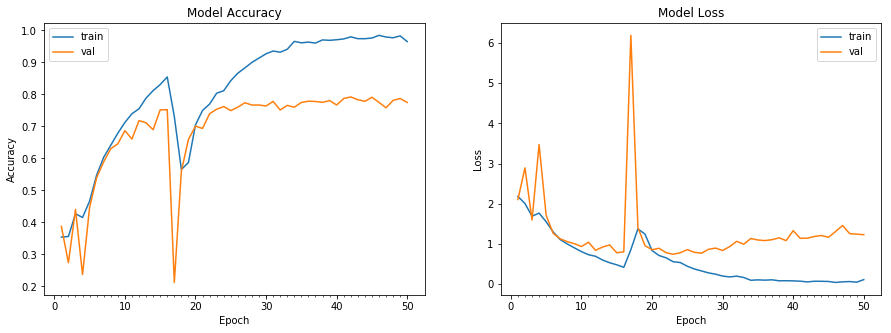

Accuracy on test data is: 77.49


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))